In [1]:
import pandas as pd
import pingouin as pg
import time
from scipy import stats
from tqdm import tqdm
import numpy as np
from pathlib import Path
import snf
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
import networkx as nx
import itertools
from copy import deepcopy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

C:\Users\colombelli\Miniconda3\envs\stellargraph\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def get_correlation_dataframe(df):
    col_1 = []
    col_2 = []
    col_r = []
    col_p = []
    
    for idx1, row1 in tqdm(df.iterrows(), total=df.shape[0]):
        for idx2, row2 in df.loc[idx1:, :].iterrows():
            r, p = stats.pearsonr(row1.values, row2.values)
            col_1.append(idx1)
            col_2.append(idx2)
            col_r.append(r)
            col_p.append(p)
            
    corr_df = pd.DataFrame.from_dict({
        "sample1": col_1,
        "sample2": col_2,
        "r": col_r,
        "p": col_p
    })
    return corr_df


def merge_correlation_dataframes(dfs):
    
    greatest_r = np.argmax(np.array([df.r for df in dfs]), axis=0)
    to_concat = [df.loc[greatest_r == i] for i, df in enumerate(dfs)]
    return pd.concat(to_concat).sort_index()


def build_edge_list(df, r_filter, p_filter):
    edges_df = df.loc[(df.r >= r_filter) & (df['p'] <= p_filter)]
    return edges_df.rename(columns={'sample1':'source', 'sample2':'target'})

def filter_relevant_connections(df, threshold):
    return df.loc[(df.weight >= threshold)]


def get_stage_class_from_patient(patient_idx, clin_df, agglutinate_stages=False):
    stage_str = clin_df.loc[patient_idx, "pathologic_stage"]
    
    if stage_str in ["stage i"+suffix for suffix in ['', 'a','b','c']]:
        return "stage1"
    elif stage_str in ["stage ii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage2"
    elif stage_str in ["stage iii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage3"
    elif stage_str in ["stage iv"+suffix for suffix in ['', 'a','b','c']]:
        return "stage4"
    else:
        return np.nan


def build_class_df(sample_idxs, agglutinate_stages=False):
    
    clin_df = pd.read_csv(f"{base}{cancer}_clin.txt", sep="\t", index_col=0).T.iloc[:, [6]]
    
    class_col = []
    for idx in sample_idxs:
        patient_idx = '-'.join(idx.split('.')[:-1]).lower()
        sample_type = int(idx.split('.')[-1])
        
        if sample_type <= 9:   # Tumor sample
            class_col.append(get_stage_class_from_patient(patient_idx, clin_df, agglutinate_stages))
        elif sample_type <= 19:   # Normal sample
            class_col.append('normal')
        elif sample_type <= 29:   # Control sample
            print(f"Warning! Found control sample {idx}, Skipping...")
            continue
        else:
            print(f"Warning! Found unexpected sample type: {idx}. Skipping...")
                  
    return pd.DataFrame.from_dict({
            "id": sample_idxs,
            "class": class_col
        }).set_index("id")


def get_consistency_index(corr_df, class_df):
    correct_connections = 0
    for index, row in corr_df.iterrows():
        src_class = class_df.loc[row[0], "class"]
        trg_class = class_df.loc[row[1], "class"]
        
        if src_class == trg_class:
            correct_connections += 1
    return correct_connections/len(corr_df)


def generate_csvs(edges_df, class_df, max_each_feature=100, multi_omics=True):
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    edges_df.to_csv(save_dir+"edges.csv", index=False)
    class_df.to_csv(save_dir+"classes.csv", index=True)
    
    gene = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).iloc[:max_each_feature, :]
    if multi_omics:
        mirna = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).iloc[:max_each_feature, :]
        meth = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).iloc[:max_each_feature, :] 
        #cnv = pd.read_csv(f"{base}{cancer}_CNV.csv", index_col=0).iloc[:max_each_feature, :]
        #features_df = pd.concat([gene,mirna,meth,cnv]).T
        features_df = pd.concat([gene,mirna,meth]).T
    else:
        features_df = gene.T
    
    features_df.loc[class_df.index, :].to_csv(save_dir+"features.csv", index=True)
    return


def get_snf_network(dfs_values_matrices, class_df, t=20, K=20):
    affinity_networks = snf.make_affinity(dfs_values_matrices, K=K)
    fused_network = snf.snf(affinity_networks, t=t)
    np.fill_diagonal(fused_network, 1)
    return fused_network
    #G = nx.from_pandas_adjacency(pd.DataFrame(data=fused_network, index=class_df.index.values, columns=class_df.index.values), create_using=nx.Graph())
    #return nx.to_pandas_edgelist(G)
    
def get_best_performance_sc(true, pred):
    classes = ['stage1','stage2','stage3','stage4']
    possible_orders = list(itertools.permutations(classes))
    pred=np.array(pred)
    
    best_acc = 0
    best_prec = 0
    best_recall = 0
    for order in possible_orders:
        replace_dict = {
            order[0]: 0,
            order[1]: 1,
            order[2]: 2,
            order[3]: 3
            }
        
        true_cp = deepcopy(true)
        for k, v in replace_dict.items(): 
            true_cp[true==k] = v

        true_cp=np.array(true_cp)
        acc = accuracy_score(list(true_cp), list(pred))
        precision, recall, _, _ = precision_recall_fscore_support(list(true_cp), list(pred))
        if acc > best_acc:
            best_acc = acc
            best_prec = precision
            best_recall = recall
            
    return best_acc, best_prec, best_recall

In [5]:
cancers = ["COAD", "KIRC", "LUAD"]
predictions = {}
true_class = {}

for cancer in cancers:
    print(cancer)
    base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

    dfs_values = []

    df1 = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
    class_df = build_class_df(list(df1.index), agglutinate_stages=False).dropna()
    dfs_values.append(df1.loc[class_df.index, :].values)

    df2 = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
    dfs_values.append(df2.loc[class_df.index, :].values)

    df3 = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
    dfs_values.append(df3.loc[class_df.index, :].values)
    
    affinity_matrix = get_snf_network(dfs_values, class_df, K=4)
    
    labels = spectral_clustering(affinity_matrix, n_clusters=4)
    predictions[cancer] = labels
    true_class[cancer] = class_df['class'].values

COAD
KIRC
LUAD


In [7]:
affinity_matrix

array([[1.        , 0.00193243, 0.00338033, ..., 0.00233398, 0.00215276,
        0.00195985],
       [0.00193243, 1.        , 0.0020546 , ..., 0.00188154, 0.00166194,
        0.00142282],
       [0.00338033, 0.0020546 , 1.        , ..., 0.00266395, 0.00184164,
        0.00173422],
       ...,
       [0.00233398, 0.00188154, 0.00266395, ..., 1.        , 0.0020989 ,
        0.00199061],
       [0.00215276, 0.00166194, 0.00184164, ..., 0.0020989 , 1.        ,
        0.0021303 ],
       [0.00195985, 0.00142282, 0.00173422, ..., 0.00199061, 0.0021303 ,
        1.        ]])

In [6]:
for cancer in cancers:
    print(cancer)
    print(get_best_performance_sc(true_class[cancer], predictions[cancer]))

COAD
(0.3049645390070922, array([0.3956044 , 0.33333333, 0.11764706, 0.2295082 ]), array([0.32142857, 0.37647059, 0.09756098, 0.31818182]))
KIRC
(0.38338658146964855, array([0.56589147, 0.1443299 , 0.43243243, 0.07692308]), array([0.48026316, 0.24137931, 0.44444444, 0.03225806]))
LUAD
(0.36629213483146067, array([0.2804878 , 0.55769231, 0.05660377, 0.20588235]), array([0.21100917, 0.47540984, 0.15789474, 0.28767123]))


In [34]:
np.count_nonzero(affinity_matrix==0)

0

In [1]:
print(round(0.2978723404255319, 2))
print(round(0.3738019169329074, 2))
print(round(0.2966292134831461, 2))

0.3
0.37
0.3


In [4]:
for cancer in cancers:
    print(cancer)
    print(get_best_performance_sc(true_class[cancer], predictions[cancer]))

COAD
(0.2978723404255319, array([0.37777778, 0.234375  , 0.12121212, 0.32631579]), array([0.30357143, 0.34090909, 0.09756098, 0.36470588]))
KIRC
(0.38338658146964855, array([0.14736842, 0.5703125 , 0.07692308, 0.41558442]), array([0.24137931, 0.48026316, 0.03225806, 0.44444444]))
LUAD
(0.2966292134831461, array([0.27906977, 0.56428571, 0.06930693, 0.18644068]), array([0.22018349, 0.32377049, 0.36842105, 0.30136986]))


In [35]:
net = get_snf_network(dfs_values, class_df, t=20)

In [143]:
net
np.fill_diagonal(net, 0)
net

array([[0.        , 0.00197029, 0.00320742, ..., 0.00230949, 0.0021638 ,
        0.00203285],
       [0.00197029, 0.        , 0.00206702, ..., 0.0019475 , 0.00175874,
        0.00157787],
       [0.00320742, 0.00206702, 0.        , ..., 0.00255541, 0.00190867,
        0.00182683],
       ...,
       [0.00230949, 0.0019475 , 0.00255541, ..., 0.        , 0.00210808,
        0.00204284],
       [0.0021638 , 0.00175874, 0.00190867, ..., 0.00210808, 0.        ,
        0.00222832],
       [0.00203285, 0.00157787, 0.00182683, ..., 0.00204284, 0.00222832,
        0.        ]])

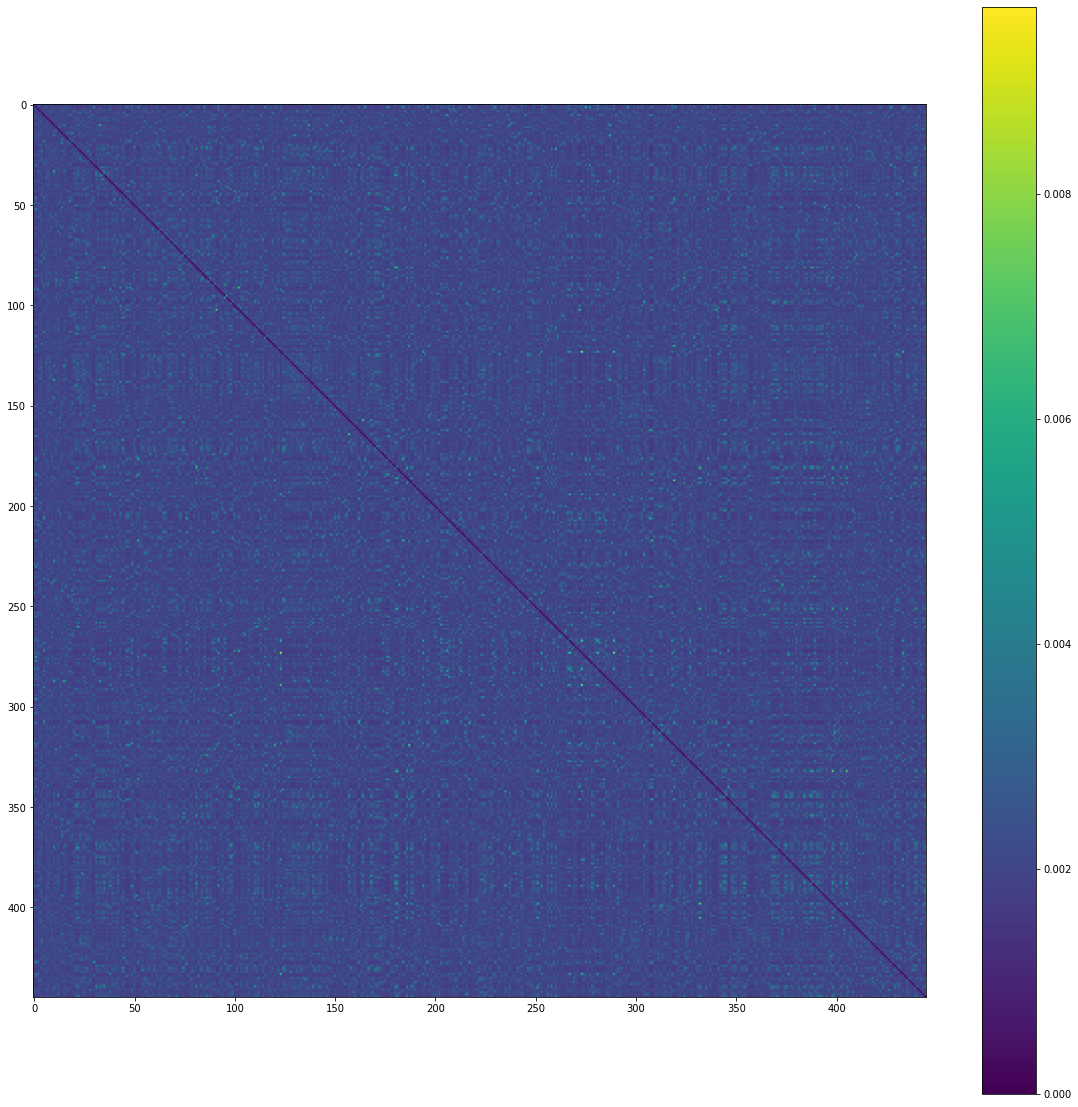

In [144]:
plt.figure(figsize=(20,20))
plt.imshow(net)
plt.colorbar()
plt.show()

In [117]:
len(df1.columns)

2000

In [74]:
net

array([[1.        , 0.00197029, 0.00320742, ..., 0.00230949, 0.0021638 ,
        0.00203285],
       [0.00197029, 1.        , 0.00206702, ..., 0.0019475 , 0.00175874,
        0.00157787],
       [0.00320742, 0.00206702, 1.        , ..., 0.00255541, 0.00190867,
        0.00182683],
       ...,
       [0.00230949, 0.0019475 , 0.00255541, ..., 1.        , 0.00210808,
        0.00204284],
       [0.0021638 , 0.00175874, 0.00190867, ..., 0.00210808, 1.        ,
        0.00222832],
       [0.00203285, 0.00157787, 0.00182683, ..., 0.00204284, 0.00222832,
        1.        ]])

In [75]:
from sklearn.neighbors import kneighbors_graph

adj_matrix = kneighbors_graph(net, n_neighbors=3, metric='precomputed',
            mode='connectivity', include_self=True).toarray()

In [76]:
adj_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
from sklearn.neighbors import kneighbors_graph

G = kneighbors_graph(df1, 3, mode='connectivity', include_self=True)
G = G.toarray()

In [50]:
import matplotlib.pyplot as plt
import networkx as nx

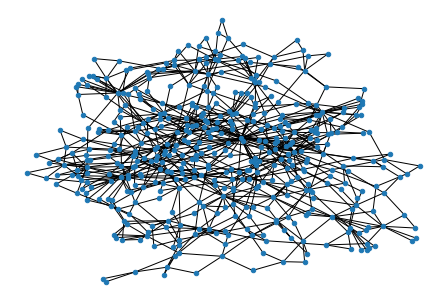

In [57]:
rows, cols = np.where(G == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=20)
plt.show()

In [60]:
labels = spectral_clustering(G, n_clusters=4)

C:\Users\colombelli\Miniconda3\envs\stellargraph\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


In [66]:
G2 = nx.from_scipy_sparse_matrix(G)
nx.draw_circular(G2)
plt.axis('equal')

AttributeError: 'numpy.ndarray' object has no attribute 'format'

In [68]:
a = "aa/bbb/ccc/"
a.split("/")[-2]

'ccc'

In [69]:
int("12")

12